### Usage Notes

* Visualizations are indexed by layer and neurons.

* There are 3 layers indices by [0,1,2].
Lots of deep learning research shows that later layers (i.e. higher indexed) should learn higher level representations of the data. Is this happening?

* There are 256 neurons total, so all indices must all be within [0,255] inclusive.

### Plots multiple neurons on a grid, useful for identifying interesting candidates

In [1]:
layer=1 # must be within [0,2] inclusive
neuron_start=64 # must be within [0,255] inclusive
neuron_end=80 # must be within [0,255] inclusive

plot_grid(layer, (neuron_start, neuron_end))

NameError: name 'plot_grid' is not defined

In [ ]:
interesting_neurons = [
    (1,0), # e.g. layer 1, neuron 0 (everything is zero-indexed)
    (1,64),
    (1,207),
    (1,87),
    (1,151),
    (2,37),
    (2,82),
    (2,243),
] 

plot_neurons(interesting_neurons)

# DO NOT EDIT BELOW THIS LINE

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from music21 import *
import pandas as pd
from matplotlib import gridspec
import h5py
import json

import sys
import seaborn as sns
sys.path.append('.')
from latexify import *

sys.path.append('/home/fl350/bachbot/scripts')
from datasets import standardize_key
from constants import *

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
utf_to_txt = json.load(open('/home/fl350/bachbot/scratch/utf_to_txt.json'))
txt_to_utf = { v:k for k,v in utf_to_txt.items() }

checkpoint_fp = '/home/fl350/bachbot/best_model/checkpoint_200'
params = json.load(open(checkpoint_fp + '.json', 'r'))
vocabs = json.load(open(params['opt']['input_json'], 'r'))
vocab_size = len(vocabs['token_to_idx'])

In [5]:
fp = '/home/fl350/data/embed/input.h5'
input_data = h5py.File(fp)[fp].value.T
is_chord_bdy = input_data ==  vocabs['token_to_idx'][txt_to_utf[CHORD_BOUNDARY_DELIM]]

In [6]:
def pool_matrix(mat, row_to_bin):
    "Pools the rows of `mat` using row_to_order"
    pooled = np.zeros((len(set(row_to_bin.values())), mat.shape[1]))
    for row_idx in range(mat.shape[0]):
        pooled[row_to_bin[row_idx],:] += mat[row_idx,:]
    return pooled

In [7]:
special_texts = [CHORD_BOUNDARY_DELIM, FERMATA_SYM, 'START', 'END']

txt_to_idx = dict(map(lambda x: (utf_to_txt[x[0]], x[1]), vocabs['token_to_idx'].items()))
idx_to_txt = { v:k for k,v in txt_to_idx.items() }
note_txt_to_idx = dict(filter(lambda x: x[0] not in special_texts, txt_to_idx.items()))

# mapping from idx in vocabulary (1-based) to sorted order index (for drawing piano roll)
# NOTE: caller usually needs to convert idx to be 0-based 
idx_to_order = dict()
curr_idx = 0
prev_midi = None
for note_txt, idx in sorted(note_txt_to_idx.items(), key=lambda x: eval(x[0])[0]): # sorted by pitch
    curr_midi = eval(note_txt)[0]
    #print prev_midi, curr_midi, (note_txt, curr_idx), 
    if prev_midi and curr_midi > prev_midi: # this collapses articulated and unarticulated version 
        curr_idx += 1
    idx_to_order[idx] = curr_idx
    prev_midi = curr_midi
for txt in special_texts:
    curr_idx += 1
    idx_to_order[vocabs['token_to_idx'][txt_to_utf[txt]]] = curr_idx
    
assert set(range(1,vocab_size+1)) == set(idx_to_order)
assert set(idx_to_order.values()) == set(range(len(set(idx_to_order.values()))))

txt_to_order = {utf_to_txt[tok]:idx_to_order[vocabs['token_to_idx'][tok]] for tok in vocabs['token_to_idx']}

In [8]:
# mapping from `order_idx` (i.e. row in piano roll) back to raw text, used for ylabels in piano roll
order_to_txt = {}
for idx, order in idx_to_order.items():
    txt = idx_to_txt[idx]
    if txt in special_texts:
        order_to_txt[order] = txt
    else:
        midiPitch = int(txt.split(',')[0][1:])
        n = note.Note()
        n.pitch.midi = midiPitch
        order_to_txt[order] = n.nameWithOctave

In [9]:
def escape_latex(s):
    return s.replace('#', '\#')

In [10]:
def plot_piano_roll(ax1, s, showRomanAnalysis=False):
    g = graph.PlotHorizontalBarPitchSpaceOffset(s)
    data, xTicks, _ = g._extractData()

    yPos = 0
    xPoints = [] # store all to find min/max
    yTicks = [] # a list of label, value pairs

    #colors = sns.color_palette("muted")
    colors = sns.color_palette("husl", 12)
    axRoman = ax1.twiny()

    keys = []
    i = 0
    for i, (key, points) in enumerate(data):
        keys.append(key)
        if len(points) > 0:
            yrange = (yPos + 1, 1)
            axRoman.broken_barh(points,
                            yrange,
                            facecolor=colors[i%len(colors)],
                            alpha=0.8)
            for xStart, xLen in points:
                xEnd = xStart + xLen
                for x in [xStart, xEnd]:
                    if x not in xPoints:
                        xPoints.append(x)
        yTicks.append([yPos + 1 * .5, key])
        yPos += 1
        i += 1

    xMin = min(xPoints)
    xMax = max(xPoints) 
    ax1.set_ylim(0, len(keys) * 1)
    ax1.set_xlim(xMin, xMax)
    axRoman.set_xlim(xMin, xMax)
    ax1.set_yticks(map(lambda x: x+1, zip(*yTicks)[0]))
    ax1.set_yticklabels(map(escape_latex, zip(*yTicks)[1]))
    ax1.set_xticks(zip(*xTicks)[0])
    ax1.set_xticklabels(map(escape_latex, zip(*xTicks)[1]))
    ax1.set_xlabel('Measure number')
    ax1.set_ylabel('Pitch')
    
    if showRomanAnalysis:
        ax1.set_title('')
        axRoman.set_xticks(romanTicks)
        axRoman.set_xticklabels(map(escape_latex, romanLabels))
        axRoman.set_xlabel('music21 Roman numeral analysis')
        axRoman.grid(zorder=0)
    
    return ax1, axRoman

### The test score used as network input

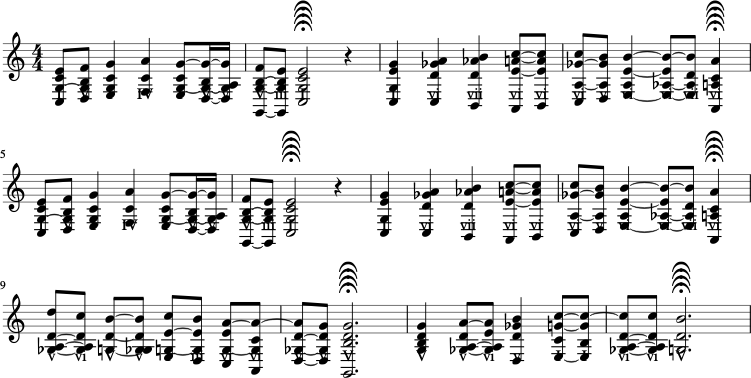

In [11]:
s = converter.parseFile('/home/fl350/data/embed/input-full.xml')
_, xTicks, _ = graph.PlotHorizontalBarPitchSpaceOffset(s)._extractData()
sRoman = s.chordify().flat
for c in sRoman.notes:
    c.lyric =  roman.romanNumeralFromChord(c, key.Key('C')).romanNumeral
sRoman.write('musicxml','input-roman.xml')

romanTicks = []
romanLabels = []
for romanNum, note in zip(sRoman.lyrics()[1], sRoman.flat.notes):
    romanTicks.append(note.offset)
    romanLabels.append(romanNum.text)
    
sRoman.show()

## Layer Activations at token level

In [12]:
layerString="""
  (1): nn.LookupTable
  (2): nn.LSTM(32 -> 256)
  (3): nn.View(6400, -1)
  (4): nn.BatchNormalization
  (5): nn.View(50, 128, -1)
  (6): nn.Dropout(0.300000)
  (7): nn.LSTM(256 -> 256)
  (8): nn.View(6400, -1)
  (9): nn.BatchNormalization
  (10): nn.View(50, 128, -1)
  (11): nn.Dropout(0.300000)
  (12): nn.LSTM(256 -> 256)
  (13): nn.View(6400, -1)
  (14): nn.BatchNormalization
  (15): nn.View(50, 128, -1)
  (16): nn.Dropout(0.300000)
  (17): nn.View(6400, -1)
  (18): nn.Linear(256 -> 108)
  (19): nn.View(50, 128, -1)
""".strip()

layerNumToName = dict()
for st in layerString.split('\n'):
    parts = st.split(':')
    layerNum = int(parts[0].strip()[1:-1])
    layerName = parts[1][3:]
    layerNumToName[layerNum] = layerName

### Confirm that final outputs correspond to a piano roll

## Look at neuron activations

In [13]:
def pool_chords(ds, is_chord_bdy, pooling_method='max', softmax_before_pool=False, temperature=1.0):
    """
    Computes token probabilities and pools across chords. Useful for making dim 2 correspond to time.
    """
    pooled_probs = np.zeros((ds.shape[0], is_chord_bdy.sum()+1))
    curr_chord_idx = 0
    for i in range(is_chord_bdy.size):
        z = ds[:,i]
        if softmax_before_pool:
            z = np.exp(z / temperature) / sum(np.exp(z) / temperature)
        if pooling_method == 'max':
            pooled_probs[:,curr_chord_idx] = np.maximum(pooled_probs[:,curr_chord_idx], z)
        elif pooling_method == 'sum':
            pooled_probs[:,curr_chord_idx] += z
        else:
            raise Exception('Unknown pooling method: {}'.format(pooling_method))
        if is_chord_bdy[i,0]:
            curr_chord_idx += 1       
    return pooled_probs

In [14]:
def load_lstm_cell(fp, pooling_method='max', softmax_before_pool=True, temperature=1.0):
    return pool_chords(h5py.File(fp)[fp].value.T, is_chord_bdy,
                       pooling_method=pooling_method,
                       softmax_before_pool=softmax_before_pool,
                       temperature=temperature)

In [15]:
def plot_neuron(ax, neuron, showRomanLabels=False):
    axRoman = ax.twiny()
    axRoman.plot(neuron)
    if showRomanLabels:
        axRoman.set_xticks(map(lambda x: 4*x, romanTicks))
        axRoman.set_xticklabels(romanLabels)        
        axRoman.set_xlim(xmax=neuron.shape[0])
    ax.set_xlim(xmax=neuron.shape[0])
    return ax

In [16]:
def plot_activations(data, fig, ax, colorbar=True):
    cax = ax.matshow(data, aspect='auto')
    ax.xaxis.set_ticks_position('bottom')
    if colorbar:
        fig.colorbar(cax)
    axRoman = ax.twiny()
    axRoman.set_xticks(romanTicks)
    axRoman.set_xticklabels(romanLabels)        
    axRoman.set_xlim([0, 64])
    fig.tight_layout()
    return axRoman

In [17]:
lstms = map(
    lambda fp: load_lstm_cell(fp, pooling_method='max', softmax_before_pool=True, temperature=1.),
    ['/home/fl350/data/embed/cell-2.h5',
    '/home/fl350/data/embed/cell-7.h5',
    '/home/fl350/data/embed/cell-12.h5'])

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


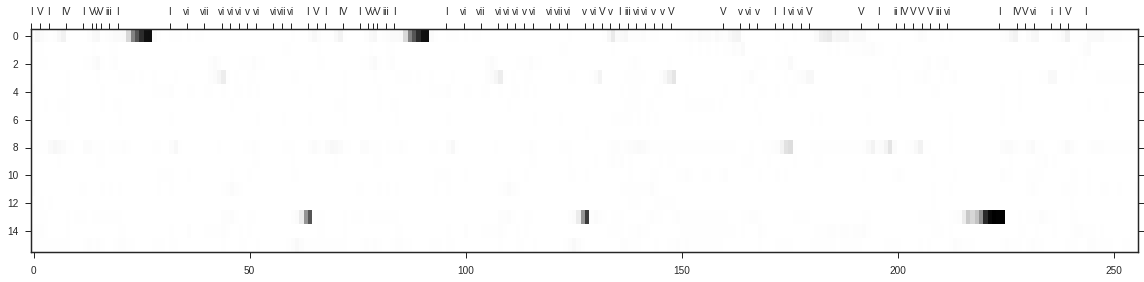

In [18]:
def plot_grid(layer, neurons):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,1, figsize=(16,4))
        axRoman = plot_activations(lstms[layer][neurons[0]:neurons[1]], fig, ax, colorbar=False)
        fig.tight_layout()
        fig.show()
    
plot_grid(1, (64,80))

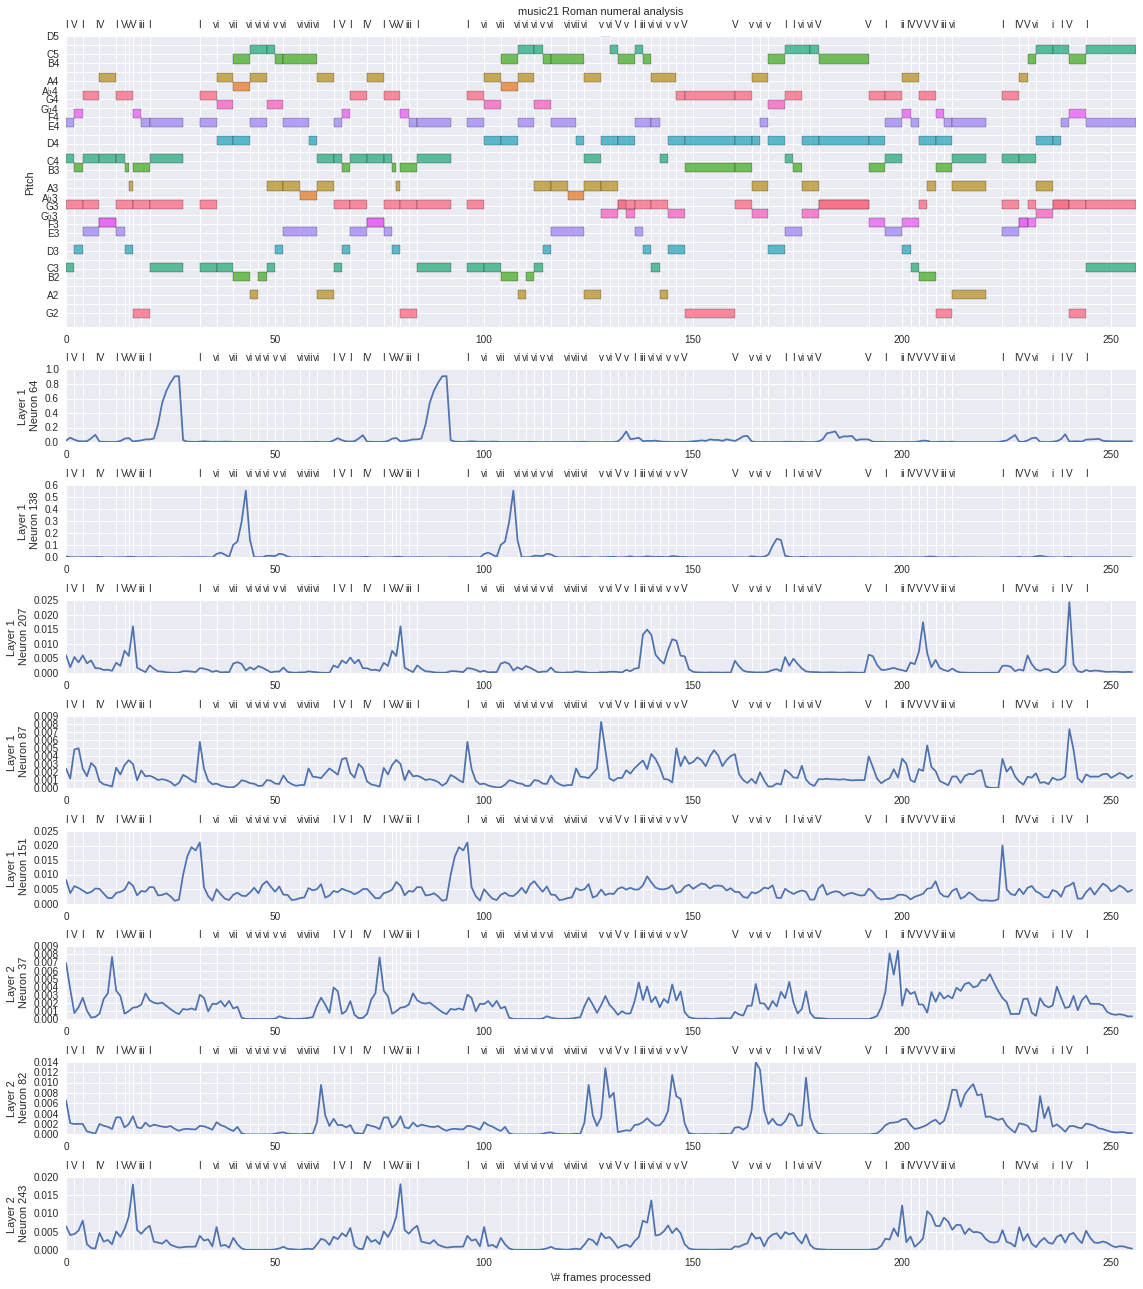

In [19]:
def plot_neurons(neurons):
    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(1+len(neurons),1, gridspec_kw = {'height_ratios':[4] + [1]*len(neurons)})

        plot_piano_roll(ax[0], s, showRomanAnalysis=True)
        ax[0].set_xticks(np.arange(0,256,12.5))
        ax[0].set_xticklabels(np.arange(0,256,50))
        ax[0].set_xlim([0, 64])
        ax[0].set_xlabel('')
        #ax[0].set_title('Neuron activations to applied stimulus\n\n\n')

    for i,neuron in enumerate(neurons):
        layer, num = neuron
        #ax[1+i].plot(lstms[layer][num:num+1].T)
        plot_neuron(ax[1+i], lstms[layer][num:num+1].T, showRomanLabels=True)
        ax[1+i].set_ylabel('Layer {}\n Neuron {}'.format(layer, num))

    ax[1+i].set_xlabel('\# frames processed')

    fig.set_size_inches((16,18))
    fig.tight_layout()
    fig.show()
    #plt.savefig('model-analysis-cells-individual.pdf', bbox_inches='tight', dpi=300)

test_neurons = [
    (1,64), # V-I detector
    (1,138), # V-I detector
    (1,207), # V detector, inversion and duration sensitive
    (1,87), # spike on I V I, small excitation on I and V
    (1,151), # motif detector
    (2,37), # I, IV transitions
    (2,82), # chord progression peaking at vi
    (2,243),# vi, v, vi
] 
plot_neurons(test_neurons)